In [1]:
import pandas as pd
from numpy.linalg import LinAlgError
import seaborn as sns
from pydci.log import enable_log, disable_log
from pydci.examples import lotka_volterra
import math 
from alive_progress import alive_bar
from pydci import PCAMUDProblem
from pydci.log import logger
import numpy as np
import pandas as pd

def solve_search(
    self,
    prob_args, 
    search_list,
    def_args = None,
    exp_thresh: float = 0.5,
    best_method: str = "closest",
):
    """
    Search through different iterations of solvign the PCA problem

    Thea idea of this method is, given a chunk of data, and a list of
    different iterative solve arguments, solve them and determine
    the "best" solution

    # TODO: Move this inside of Model class: self -> self

    Parameters
    ----------
    """

    am = ["closest", "min_kl", "max_kl"]
    if best_method not in am:
        msg = f"Unrecognized best method {best_method}. Allowed: {am}"
        raise ValueError(msg)
    if exp_thresh <= 0:
        msg = f"Expected ratio thresh must be a float > 0: {exp_thresh}"
        raise ValueError(msg)

    all_search_results = []
    all_results = []
    with alive_bar(
        len(search_list),
        title="Solving for different combinations",
        force_tty=True,
        receipt=True,
        length=40,
    ) as bar:
        for idx, args in enumerate(search_list):
            args.update(def_args if def_args is not None else {})

            # Solve -> Saves states in state dictionary
            prob = PCAMUDProblem(prob_args['samples'],
                                 prob_args['data'],
                                 self.measurement_noise,
                                 pi_in=prob_args['pi_in'])
                                 
            try:
                prob.solve_it(**args, state_extra={"search_index": idx})
            except ZeroDivisionError or KDEError as e:
                logger.error(f"Failed: Ill-posed problem: {e}")
                continue 
            except RuntimeError as r:
                if "No solution found within exp_thresh" in str(r):
                    logger.error(f"Failed: No solution in exp_thresh: {r}")
                    continue
                else:
                    raise r
            except LinAlgError as e:
                logger.exception(str(e))
                return prob
            else:
                # ! What state do we need to whipe here to ensure back to original conditions of search on next iteration?
                # Store results per each iteration and final result
                # This will be erased the next iteration if we don't store it
                all_search_results.append(prob.it_results.copy())
                all_search_results[-1]["index"] = idx
                all_results.append(prob.result.copy())
                all_results[-1]["index"] = idx

            bar()

    # Parse DataFrame with results of mud estimations for each ts choice
    res_df = pd.concat(all_results)
    res_df["predict_delta"] = np.abs(res_df["e_r"] - 1.0)
    res_df["within_thresh"] = res_df["predict_delta"] <= exp_thresh
    res_df["closest"] = np.logical_and(
        res_df["predict_delta"]
        <= res_df[res_df["within_thresh"]]["predict_delta"].min(),
        res_df["within_thresh"],
    )
    res_df["max_kl"] = np.logical_and(
        res_df["kl"] >= res_df[res_df["within_thresh"]]["kl"].max(),
        res_df["within_thresh"],
    )
    res_df["min_kl"] = np.logical_and(
        res_df["kl"] <= res_df[res_df["within_thresh"]]["kl"].min(),
        res_df["within_thresh"],
    )

    # Set to best
    search_results = res_df
    all_search_results = pd.concat(all_search_results) # Has internal iterations for each try
    result = res_df[res_df[best_method]]

    if len(result) == 0:
        raise RuntimeError(f'No solution found within exp_thresh')
    else:
        # Re-solve Using Best
        best = PCAMUDProblem(prob_args['samples'],
                             prob_args['data'],
                             self.measurement_noise,
                             pi_in=prob_args['pi_in'])
        try:
            logger.info(f"Resolving with best result: {result['index'].values[0]}")
            best.solve_it(**search_list[result['index'].values[0]])
        except LinAlgError as e:
            return best
    
    return {'best': best, 'search_results': search_results, 'all_search_results': all_search_results}


def get_search_combinations(self,
                            data_idx=-1,
                            exp_thresh=1e10,
                            max_nc=5,
                            ):
    """
    """
    if len(self.data) == 0 or data_idx > len(self.data):
        raise ValueError(f"Invalid data_idx: {data_idx}. Data length: {len(self.data)}")
    df = self.data[data_idx]
    sampled_data = df[df['sample_flag']]
    n_data = len(sampled_data) *  self.n_states
    data_chunk_size = self.n_params if self.n_params <= n_data else n_data

    def order_of_magnitude(n):
        return int(math.log10(n)) + 1

    # * Restrict max number of principle components by number of sensors available
    # * Or else KDEs will fail on higher dimensional data.
    max_nc = min(order_of_magnitude(len(self.samples[data_idx])), max_nc)

    # * PCA component variations -> Dependent on sample size (and # of data points if <= n_params)
    # First choose # of principle components to use. 
    # Start with just doing all possible:  1->data_chunk_size.
    # TODO: Future -> Use sample size to determine how many components to use (dimenionalsity of problem)
    # * Data Mask -> What percent of total data to use
    # * Increasing chunks of data_chunk_size.
    search_list = [
        {
            'exp_thresh': exp_thresh,
            'pca_components': [list(range(i + 1))],
            'pca_mask': range(j),
            'pca_splits': k,
        }
        for i in range(min(max_nc, data_chunk_size))
        for j in range(data_chunk_size, n_data, data_chunk_size)
        for k in range(1, (n_data + 1)%data_chunk_size + 1)
        if j/(k*data_chunk_size) >= 1.0 
    ]

    return search_list

enable_log()

[07/21/23 09:58:04] INFO     Logger initialized                                                           ]8;id=330117;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=146545;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

# Initialize Problem

In [2]:
# Initialize Problem
num_samples = 100
lvm = lotka_volterra.LotkaVolterraModel(sample_ts=0.5,
                                        measurement_noise=2)

# Get initial samples
pi_in, samples = lvm.get_uniform_initial_samples(num_samples=num_samples, scale=0.5)

res = {'res': [], 'samples': []}
time_step = 4
max_its = 10

i = 0
t = 0
best_flag = np.empty((num_samples, 1), dtype=bool)
while i < max_its:
    t += time_step
    f_res = lvm.forward_solve(t, samples=samples)
    search_combs = get_search_combinations(
        lvm, exp_thresh=1e10)

    # disable_log()
    enable_log(level='DEBUG', file='test.log')
    prob_args = {'samples': f_res['samples'],
                'data': f_res['data'],
                'pi_in': pi_in}
    search_res = solve_search(lvm, prob_args, search_combs, exp_thresh=1e10, best_method='closest')
    res['res'].append(search_res)
    res['samples'].append(samples)
    best_flag[:] = False
    best_flag[search_res['best'].mud_arg] = True
    lvm.samples[i]["best_flag"] = best_flag
    samples = search_res['best'].sample_dist(num_samples=num_samples, dist='pi_up')
    i += 1


[07/21/23 09:58:06] INFO     Drawing 100 from uniform at:                                              ]8;id=463729;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=110221;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#256\256]8;;\
                                     loc: [0.5   0.01  0.005 0.5  ]                                                
                                     scale: [1.   0.02 0.01 1.  ]                                                  

                    INFO     Starting forward solve.                                                   ]8;id=82998;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=629977;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#152\152]8;;\

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (9,) (2,) 

In [3]:
search_res['best'].dists['pi_up'].pdf(lvm.lam_true)

array([3311685.89910108])

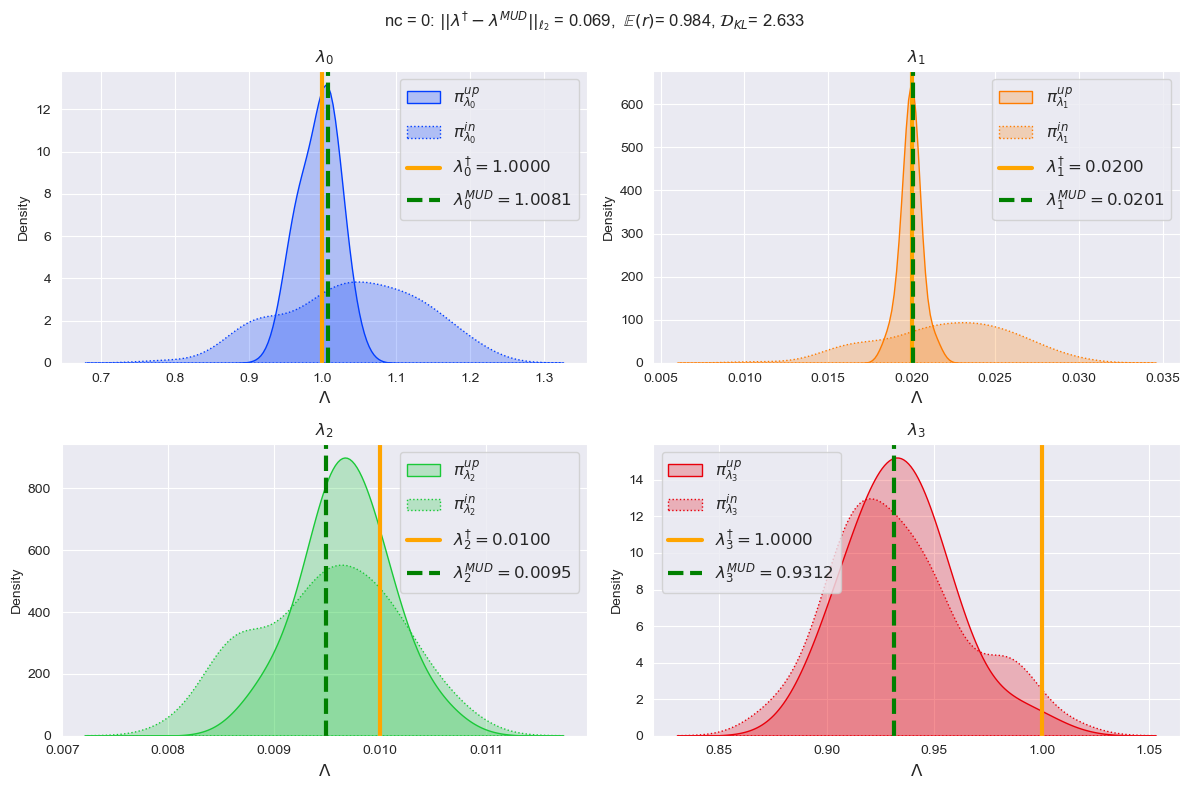

In [4]:
# TODO : Plot first initial and final at the end of the iterations.
# TODO: First update - and last update.
search_res['best'].param_density_plots(lam_true=lvm.lam_true, plot_mud=True)

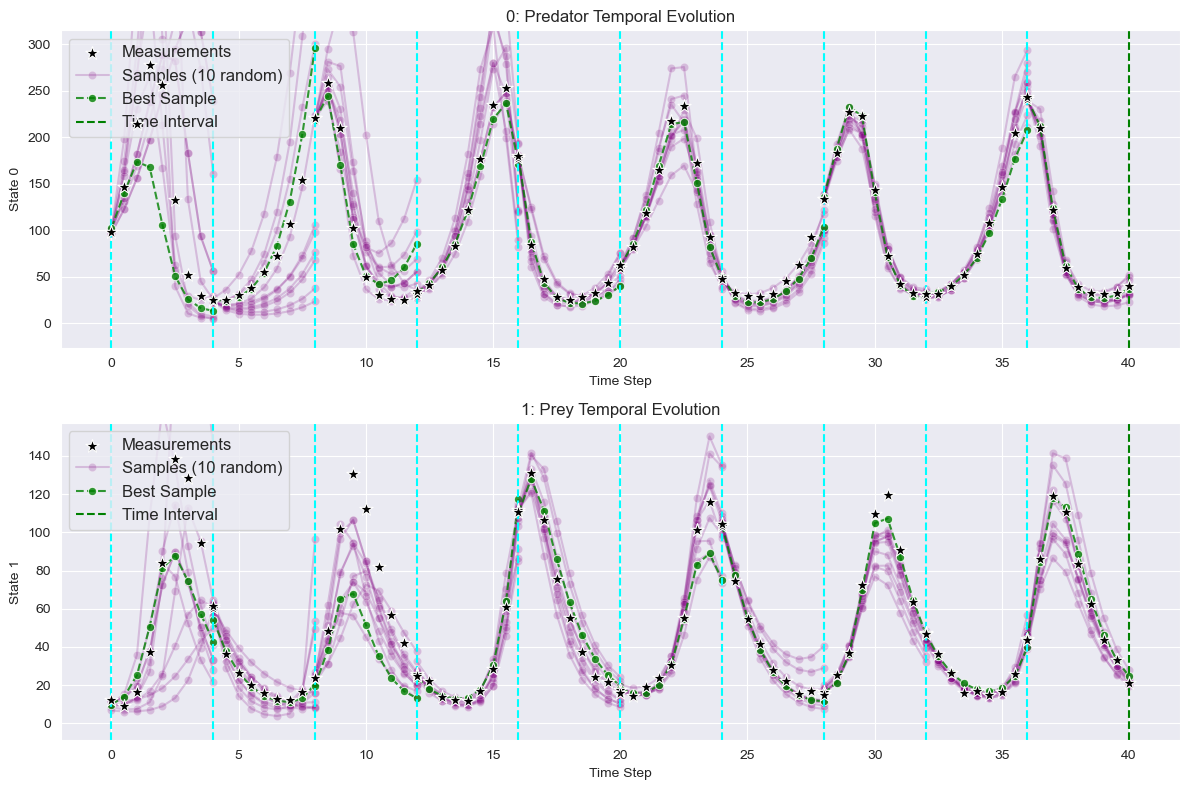

In [5]:
lvm.plot_states(plot_true=False)

In [6]:
search_res['search_results']

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.077548,1.191602,0.972296,0.018789,0.010105,0.992744,33,[0],"range(0, 4)",0,0,0.077548,True,False,False,False
0,0.623006,2.662856,0.917820,0.018722,0.010707,0.915322,27,[0],"range(0, 8)",0,1,0.376994,True,False,False,False
0,0.713831,1.853431,0.971345,0.019565,0.009966,0.944934,26,[0],"range(4, 8)",1,2,0.286169,True,False,False,False
0,0.409709,2.771169,1.013457,0.021401,0.009590,0.898650,37,[0],"range(0, 12)",0,3,0.590291,True,False,False,False
0,0.278148,1.345060,1.051138,0.021149,0.008852,0.893361,38,[0],"range(6, 12)",1,4,0.721852,True,False,False,False
0,0.058053,1.450447,1.040756,0.021004,0.009065,0.903580,43,[0],"range(8, 12)",2,5,0.941947,True,False,False,False
0,1.141677,2.318588,0.991505,0.021066,0.010006,0.925043,2,[0],"range(0, 16)",0,6,0.141677,True,False,False,False
0,0.008706,1.717594,1.040756,0.021004,0.009065,0.903580,43,[0],"range(8, 16)",1,7,0.991294,True,False,False,False
0,0.911079,1.197519,1.051138,0.021149,0.008852,0.893361,38,[0],"range(6, 11)",1,8,0.088921,True,False,False,False
0,0.984423,2.633365,1.008078,0.020071,0.009492,0.931160,3,"[0, 1]","range(0, 4)",0,9,0.015577,True,True,False,False


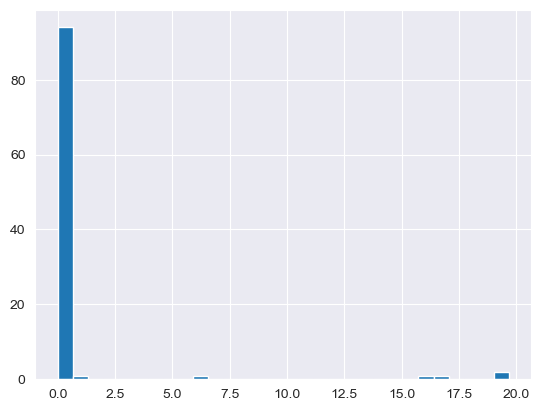

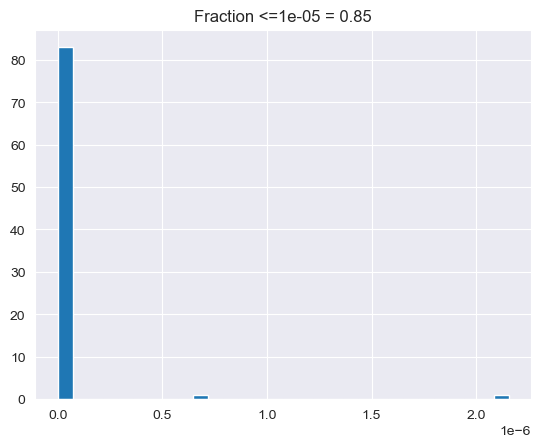

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# create sample data

# plot histogram
bound = 1e-5
up_weights = search_res['best'].state['ratio']*search_res['best'].state['weight']
leq_1 = up_weights[up_weights <= bound]
plt.hist(up_weights, bins=30)
plt.show()

plt.hist(leq_1, bins=30)
plt.title(f'Fraction <={bound} = {len(leq_1)/len(up_weights)}')
plt.show()